# Load and Enrich multiple file types Azure Cognitive Search

In this Jupyter Notebook, we create and run enrichment steps to unlock searchable content in the specified Azure blob. It performs operations over mixed content in Azure Storage, such as images and application files, using a skillset that analyzes and extracts text information that becomes searchable in Azure Cognitive Search. 
The reference sample can be found at [Tutorial: Use Python and AI to generate searchable content from Azure blobs](https://docs.microsoft.com/azure/search/cognitive-search-tutorial-blob-python).

In this demo we are going to be using a private (so we can mimic a private data lake scenario) Blob Storage container that has ~9.8k Computer Science publication PDFs from the Arxiv dataset.
https://www.kaggle.com/datasets/Cornell-University/arxiv

If you want to explore the dataset, go [HERE](https://console.cloud.google.com/storage/browser/arxiv-dataset/arxiv/cs/pdf?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false)<br>
Note: This dataset has been copy to a public azure blob container for this demo

Although only  PDF files are used here, this can be done at a much larger scale and Azure Cognitive Search supports a range of other file formats including: Microsoft Office (DOCX/DOC, XSLX/XLS, PPTX/PPT, MSG), HTML, XML, ZIP, and plain text files (including JSON).
Azure Search support the following sources: [Data Sources Gallery](https://learn.microsoft.com/EN-US/AZURE/search/search-data-sources-gallery)

This notebook creates the following objects on your search service:

+ data source
+ skillset
+ search index
+ indexer

This notebook calls the [Search REST APIs](https://docs.microsoft.com/rest/api/searchservice/), but you can also use the Azure.Search.Documents client library in the Azure SDK for Python to perform the same steps. See this [Python quickstart](https://docs.microsoft.com/azure/search/search-get-started-python) for details.

To run this notebook, you should have already created the Azure services on README. Once you've done this, you can run all cells, but the query won't return results until the indexer is finished and the search index is loaded. 

We recommend running each step and making sure it completes before moving on.

![cog-search](./images/Cog-Search-Enrich.png)

In [1]:
import os
import json
import requests
from dotenv import load_dotenv
load_dotenv("credentials (my).env")

# Name of the container in your Blob Storage Datasource ( in credentials.env)
BLOB_CONTAINER_NAME = "arxivcs"

In [2]:
# Define the names for the data source, skillset, index and indexer
datasource_name = "cogsrch-datasource-files"
skillset_name   = "cogsrch-skillset-files"
index_name      = "cogsrch-index-files"
indexer_name    = "cogsrch-indexer-files"

In [3]:
# Setup the Payloads header
headers = {'Content-Type': 'application/json','api-key': os.environ['AZURE_SEARCH_KEY']}
params = {'api-version': os.environ['AZURE_SEARCH_API_VERSION']}

## Create Data Source (Blob container with the Arxiv CS pdfs)
### Recall to enable soft delete for blobs un DATA PROTECTION:
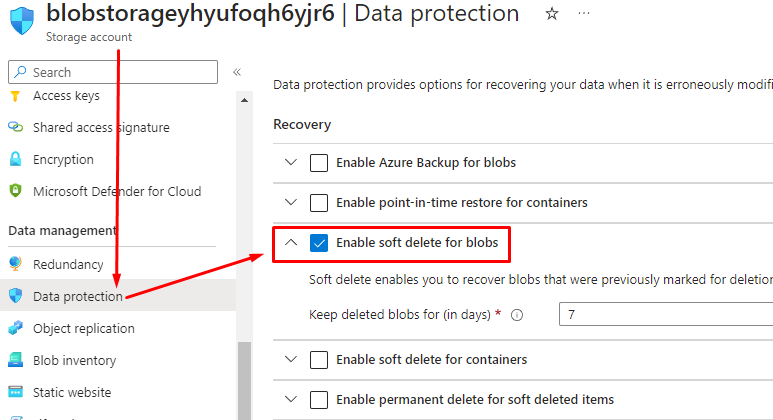

In [9]:
# The following code sends the json paylod to Azure Search engine to create the Datasource

datasource_payload = {
    "name": datasource_name,
    "description": "Demo files to demonstrate cognitive search capabilities.",
    "type": "azureblob",
    "credentials": {
        "connectionString": os.environ['BLOB_CONNECTION_STRING']
    },
    "dataDeletionDetectionPolicy" : {
        "@odata.type" :"#Microsoft.Azure.Search.NativeBlobSoftDeleteDeletionDetectionPolicy" # this makes sure that if the item is deleted from the source, it will be deleted from the index
    },
    "container": {
        "name": BLOB_CONTAINER_NAME
    }
}
r = requests.put(os.environ['AZURE_SEARCH_ENDPOINT'] + "/datasources/" + datasource_name,
                 data=json.dumps(datasource_payload), headers=headers, params=params)
print(r.status_code)
print(r.ok)

201
True


- 201 - Successfully created
- 204 - Succesfully overwritten
- 40X - Authentication Error

For information on Change and Delete file detection please see [HERE](https://learn.microsoft.com/en-us/azure/search/search-howto-index-changed-deleted-blobs?tabs=rest-api)

In [8]:
# If you have a 403 code, probably you have a wrong endpoint or key, you can debug by uncomment this
r.text

'{"error":{"code":"","message":"Data source name must only contain lowercase letters, digits or dashes, cannot start or end with dashes and is limited to 128 characters."}}'

## Create Skillset - OCR, Text Splitter, Language Detection, KeyPhrase extraction, Entity Recognition

We need to create now the skillset. This is a set of steps in which we use many Cognitive Services to enrich the documents by extracting information, applying OCR, translating, etc.

https://learn.microsoft.com/en-us/azure/search/cognitive-search-working-with-skillsets

https://learn.microsoft.com/en-us/azure/search/cognitive-search-predefined-skills


In [ ]:
# Create a skillset
skillset_payload = {
    "name": skillset_name,
    "description": "Extract entities, detect language and extract key-phrases",
    "skills":
    [
        {
            "@odata.type": "#Microsoft.Skills.Vision.OcrSkill",
            "description": "Extract text (plain and structured) from image.",
            "context": "/document/normalized_images/*",
            "defaultLanguageCode": "en",
            "detectOrientation": True,
            "inputs": [
                {
                  "name": "image",
                  "source": "/document/normalized_images/*"
                }
            ],
                "outputs": [
                {
                  "name": "text",
                  "targetName" : "images_text"
                }
            ]
        },
        {
            "@odata.type": "#Microsoft.Skills.Text.MergeSkill",
            "description": "Create merged_text, which includes all the textual representation of each image inserted at the right location in the content field. This is useful for PDF and other file formats that supported embedded images.",
            "context": "/document",
            "insertPreTag": " ",
            "insertPostTag": " ",
            "inputs": [
                {
                  "name":"text", "source": "/document/content"
                },
                {
                  "name": "itemsToInsert", "source": "/document/normalized_images/*/images_text"
                },
                {
                  "name":"offsets", "source": "/document/normalized_images/*/contentOffset"
                }
            ],
            "outputs": [
                {
                  "name": "mergedText", 
                  "targetName" : "merged_text"
                }
            ]
        },
        {
            "@odata.type": "#Microsoft.Skills.Text.LanguageDetectionSkill",
            "context": "/document",
            "description": "If you have multilingual content, adding a language code is useful for filtering",
            "inputs": [
                {
                  "name": "text",
                  "source": "/document/content"
                }
            ],
            "outputs": [
                {
                  "name": "languageCode",
                  "targetName": "language"
                }
            ]
        },
        {
            "@odata.type": "#Microsoft.Skills.Text.SplitSkill",
            "context": "/document",
            "textSplitMode": "pages",
            "maximumPageLength": 5000, # 5000 is default
            "defaultLanguageCode": "en",
            "inputs": [
                {
                    "name": "text",
                    "source": "/document/merged_text"
                },
                {
                    "name": "languageCode",
                    "source": "/document/language"
                }
            ],
            "outputs": [
                {
                    "name": "textItems",
                    "targetName": "pages"
                }
            ]
        },
        {
            "@odata.type": "#Microsoft.Skills.Text.KeyPhraseExtractionSkill",
            "context": "/document/pages/*",
            "maxKeyPhraseCount": 2,
            "defaultLanguageCode": "en",
            "inputs": [
                {
                    "name": "text", 
                    "source": "/document/pages/*"
                },
                {
                    "name": "languageCode",
                    "source": "/document/language"
                }
            ],
            "outputs": [
                {
                    "name": "keyPhrases",
                    "targetName": "keyPhrases"
                }
            ]
        },
        {
            "@odata.type": "#Microsoft.Skills.Text.V3.EntityRecognitionSkill",
            "context": "/document/pages/*",
            "categories": ["Person", "URL", "Email"],
            "minimumPrecision": 0.5, 
            "defaultLanguageCode": "en",
            "inputs": [
                {
                    "name": "text", 
                    "source":"/document/pages/*"
                },
                {
                    "name": "languageCode",
                    "source": "/document/language"
                }
            ],
            "outputs": [
                {
                    "name": "persons", 
                    "targetName": "persons"
                },
                {
                    "name": "urls", 
                    "targetName": "urls"
                },
                {
                    "name": "emails", 
                    "targetName": "emails"
                }
            ]
        }
    ],
    "cognitiveServices": {
        "@odata.type": "#Microsoft.Azure.Search.CognitiveServicesByKey",
        "description": os.environ['COG_SERVICES_NAME'],
        "key": os.environ['COG_SERVICES_KEY']
    }
}

r = requests.put(os.environ['AZURE_SEARCH_ENDPOINT'] + "/skillsets/" + skillset_name,
                 data=json.dumps(skillset_payload), headers=headers, params=params)
print(r.status_code)
print(r.ok)

## Create Index

In Azure Cognitive Search, a search index is your searchable content, available to the search engine for indexing, full text search, and filtered queries. An index is defined by a schema and saved to the search service. This content exists within your search service, apart from your primary data stores, which is necessary for the millisecond response times expected in modern applications. Except for specific indexing scenarios, the search service will never connect to or query your local data.

The body of the request defines the schema of the search index. A fields collection requires one field to be designated as the key. For blob type, this field is often the "metadata_storage_path" that uniquely identifies each file in the container.

Reference:

https://learn.microsoft.com/en-us/azure/search/search-what-is-an-index

In [ ]:
# Create an index
# Queries operate over the searchable fields and filterable fields in the index
index_payload = {
    "name": index_name,
    "fields": [
        {"name": "id", "type": "Edm.String", "key": "true", "searchable": "false", "retrievable": "true", "sortable": "false", "filterable": "false","facetable": "false"},
        {"name": "title", "type": "Edm.String", "searchable": "true", "retrievable": "true", "facetable": "false", "filterable": "true", "sortable": "false"},
        {"name": "content", "type": "Edm.String", "searchable": "true", "retrievable": "true", "sortable": "false", "filterable": "false","facetable": "false"},
        {"name": "chunks","type": "Collection(Edm.String)", "searchable": "false", "retrievable": "true", "sortable": "false", "filterable": "false", "facetable": "false"},
        {"name": "language", "type": "Edm.String", "searchable": "false", "retrievable": "true", "sortable": "true", "filterable": "true", "facetable": "true"},
        {"name": "name", "type": "Edm.String", "searchable": "true", "retrievable": "true", "sortable": "false", "filterable": "false", "facetable": "false"},
        {"name": "location", "type": "Edm.String", "searchable": "false", "retrievable": "true", "sortable": "false", "filterable": "false", "facetable": "false"},
        {"name": "vectorized", "type": "Edm.Boolean", "searchable": "false", "retrievable": "true", "sortable": "false", "filterable": "false", "facetable": "false"},
        {"name": "images_text", "type": "Collection(Edm.String)", "searchable": "true", "retrievable": "true", "sortable": "false", "filterable": "false", "facetable": "false"},
        {"name": "keyPhrases", "type": "Collection(Edm.String)", "searchable": "true", "retrievable": "true", "sortable": "false", "filterable": "true", "facetable": "true"},
        {"name": "persons", "type": "Collection(Edm.String)", "searchable": "true", "retrievable": "true", "sortable": "false", "filterable": "false", "facetable": "false"},
        {"name": "urls", "type": "Collection(Edm.String)", "searchable": "false", "retrievable": "true", "sortable": "false", "filterable": "false", "facetable": "false"},
        {"name": "emails", "type": "Collection(Edm.String)", "searchable": "true", "retrievable": "true", "sortable": "false", "filterable": "true", "facetable": "false"}
        
    ],
    "semantic": {
      "configurations": [
        {
          "name": "my-semantic-config",
          "prioritizedFields": {
            "titleField": 
                {
                    "fieldName": "title"
                },
            "prioritizedContentFields": [
                {
                    "fieldName": "content"
                }
                ]
          }
        }
      ]
    }
}

r = requests.put(os.environ['AZURE_SEARCH_ENDPOINT'] + "/indexes/" + index_name,
                 data=json.dumps(index_payload), headers=headers, params=params)
print(r.status_code)
print(r.ok)

In [ ]:
#print(r.text)

### Semantic Search capabilities
As you can see above in the index payload, there is a `semantic configuration`. What is that?

Azure Search has a feature called: Semantic Search. This is a Deep Neural Network that lives on the engine that tries to find results based on the semantic meaning of the query and the content, not keyword mathching/counting. 
From the [official documentation](https://learn.microsoft.com/en-us/azure/search/semantic-search-overview):

Semantic search is a collection of features that improve the quality of initial search results for text-based queries. When you enable it on your search service, semantic search extends the query execution pipeline in two ways:

- First, it adds secondary ranking over an initial result set, promoting the most semantically relevant results to the top of the list.

- Second, it extracts and returns captions and answers in the response, which you can render on a search page to improve the user's search experience.

For deeper explanation and limitations see [HERE](https://learn.microsoft.com/en-us/azure/search/semantic-ranking)

## Create and Run the Indexer - (runs the pipeline)

The three components you have created thus far (data source, skillset, index) are inputs to an indexer. Creating the indexer on Azure Cognitive Search is the event that puts the entire pipeline into motion.

In [ ]:
# Create an indexer
indexer_payload = {
    "name": indexer_name,
    "dataSourceName": datasource_name,
    "targetIndexName": index_name,
    "skillsetName": skillset_name,
    "schedule" : { "interval" : "PT2H"}, # How often do you want to check for new content in the data source
    "fieldMappings": [
        {
          "sourceFieldName" : "metadata_storage_path",
          "targetFieldName" : "id",
          "mappingFunction" : { "name" : "base64Encode" }
        },
        {
          "sourceFieldName" : "metadata_title",
          "targetFieldName" : "title"
        },
        {
          "sourceFieldName" : "metadata_storage_name",
          "targetFieldName" : "name"
        },
        {
          "sourceFieldName" : "metadata_storage_path",
          "targetFieldName" : "location"
        }
    ],
    "outputFieldMappings":
    [
        {
            "sourceFieldName": "/document/merged_text",
            "targetFieldName": "content"
        },
        {
            "sourceFieldName": "/document/pages/*",
            "targetFieldName": "chunks"
        },
        {
            "sourceFieldName" : "/document/normalized_images/*/images_text",
            "targetFieldName" : "images_text"
        },
        {
            "sourceFieldName": "/document/language",
            "targetFieldName": "language"
        },
        {
            "sourceFieldName": "/document/pages/*/keyPhrases/*",
            "targetFieldName": "keyPhrases"
        },
        {
          "sourceFieldName" : "/document/pages/*/persons/*", 
          "targetFieldName" : "persons"
        },
        {
            "sourceFieldName": "/document/pages/*/urls/*",
            "targetFieldName": "urls"
        },
        {
            "sourceFieldName": "/document/pages/*/emails/*",
            "targetFieldName": "emails"
        }
    ],
    "parameters":
    {
        "maxFailedItems": -1,
        "maxFailedItemsPerBatch": -1,
        "configuration":
        {
            "dataToExtract": "contentAndMetadata",
            "imageAction": "generateNormalizedImages"
        }
    }
}

r = requests.put(os.environ['AZURE_SEARCH_ENDPOINT'] + "/indexers/" + indexer_name,
                 data=json.dumps(indexer_payload), headers=headers, params=params)
print(r.status_code)
print(r.ok)

In [ ]:
# Uncomment if you find an error
# r.text

Note: If you get a 400 unauthorize error, make sure that you are using the Azure Search MANAGEMENT KEY, not the QUERY key

In [ ]:
# Optionally, get indexer status to confirm that it's running
r = requests.get(os.environ['AZURE_SEARCH_ENDPOINT'] + "/indexers/" + indexer_name +
                 "/status", headers=headers, params=params)
# pprint(json.dumps(r.json(), indent=1))
print(r.status_code)
print("Status:",r.json().get('lastResult').get('status'))
print("Items Processed:",r.json().get('lastResult').get('itemsProcessed'))
print(r.ok)

**When the indexer finishes running we will have all 9.8k documents indexed in your Search Engine!.**

## Creation of its corresponding vector-based index
### ...without filling the data, for the moment (will be in Notebook #4)

**Azure Cognitive Search has now vector search capabilities** ([Watch this video](https://aka.ms/Vector_SearchSnackableVideo)). The advantages of vector search in Azure Cognitive Search include its integration with other capabilities of Azure Cognitive Search, the ability to use any type of data (text, image, audio, video, etc) from diverse Azure datastores to inform a single generative AI-powered application, and the support of vector fields in the search indexes. It also offers pure vector search, hybrid retrieval, and a sophisticated re-ranking system powered by Bing in a single integrated solution (check the release [blog site](https://techcommunity.microsoft.com/t5/azure-ai-services-blog/announcing-vector-search-in-azure-cognitive-search-public/ba-p/3872868)).


![vector-search](https://techcommunity.microsoft.com/t5/image/serverpage/image-id/489211i001E2B9B34F483C2/image-dimensions/876x416?v=v2)


**The main limitations (for now) of vector search in Azure Cognitive Search are:**

- It does not generate vector embeddings for the content. Users need to provide the embeddings themselves by using a service such as Azure OpenAI.
- There is not field type for Collection of vectors, meaning that each document in the vector-based index must be either a small document or a chunk of a bigger document.

We are going to come back to these limitations and solve them in the next notebooks, but for now let's just create our corresponding vector-based index

In [ ]:
index_payload = {
    "name": index_name + "-vector",
    "fields": [
        {"name": "id", "type": "Edm.String", "key": "true", "filterable": "true" },
        {"name": "title","type": "Edm.String","searchable": "true","retrievable": "true"},
        {"name": "chunk","type": "Edm.String","searchable": "true","retrievable": "true"},
        {"name": "chunkVector","type": "Collection(Edm.Single)","searchable": "true","retrievable": "true","dimensions": 1536,"vectorSearchConfiguration": "vectorConfig"},
        {"name": "name", "type": "Edm.String", "searchable": "true", "retrievable": "true", "sortable": "false", "filterable": "false", "facetable": "false"},
        {"name": "location", "type": "Edm.String", "searchable": "false", "retrievable": "true", "sortable": "false", "filterable": "false", "facetable": "false"},

    ],
    "vectorSearch": {
        "algorithmConfigurations": [
            {
                "name": "vectorConfig",
                "kind": "hnsw"
            }
        ]
    },
    "semantic": {
        "configurations": [
            {
                "name": "my-semantic-config",
                "prioritizedFields": {
                    "titleField": {
                        "fieldName": "title"
                    },
                    "prioritizedContentFields": [
                        {
                            "fieldName": "chunk"
                        }
                    ],
                    "prioritizedKeywordsFields": []
                }
            }
        ]
    }
}

r = requests.put(os.environ['AZURE_SEARCH_ENDPOINT'] + "/indexes/" + index_name + "-vector",
                 data=json.dumps(index_payload), headers=headers, params=params)
print(r.status_code)
print(r.ok)

# References

- https://learn.microsoft.com/en-us/azure/search/cognitive-search-tutorial-blob
- https://github.com/Azure-Samples/azure-search-python-samples/blob/main/Tutorial-AI-Enrichment/PythonTutorial-AzureSearch-AIEnrichment.ipynb
- https://github.com/Azure/azure-sdk-for-python/tree/main/sdk/search/azure-search-documents/samples
- https://learn.microsoft.com/en-us/azure/search/search-get-started-python
- https://github.com/Azure-Samples/azure-search-python-samples/blob/main/Tutorial-AI-Enrichment/PythonTutorial-AzureSearch-AIEnrichment.ipynb

# NEXT
In the next notebook 02, we will implement another type of indexing call One-to-Many, in which a single CSV or JSON file can be converted into multiple individual searchable documents in Azure Search. 